In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(palette="Set2")

from sklearn.metrics import mean_squared_error
from datetime import datetime
from scalecast.Forecaster import Forecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load data

In [2]:
df = pd.read_csv("currencies.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d%b%Y")
df.set_index("Date", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3988 entries, 2002-07-07 to 2013-06-06
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR     3988 non-null   float64
 1   GBP     3988 non-null   float64
 2   JPY     3988 non-null   float64
dtypes: float64(3)
memory usage: 124.6 KB


In [3]:
df.describe()

,EUR,GBP,JPY
count,3988.000000,3988.000000,3988.000000
mean,0.778258,0.589061,101.926707
std,0.079459,0.056646,14.699658
min,0.626900,0.475100,75.839000
25%,0.730500,0.538600,89.393300
50%,0.770050,0.607100,105.771000
75%,0.815100,0.633900,115.845500
max,1.035300,0.728300,125.560000


# EDA

<Axes: xlabel='Date'>

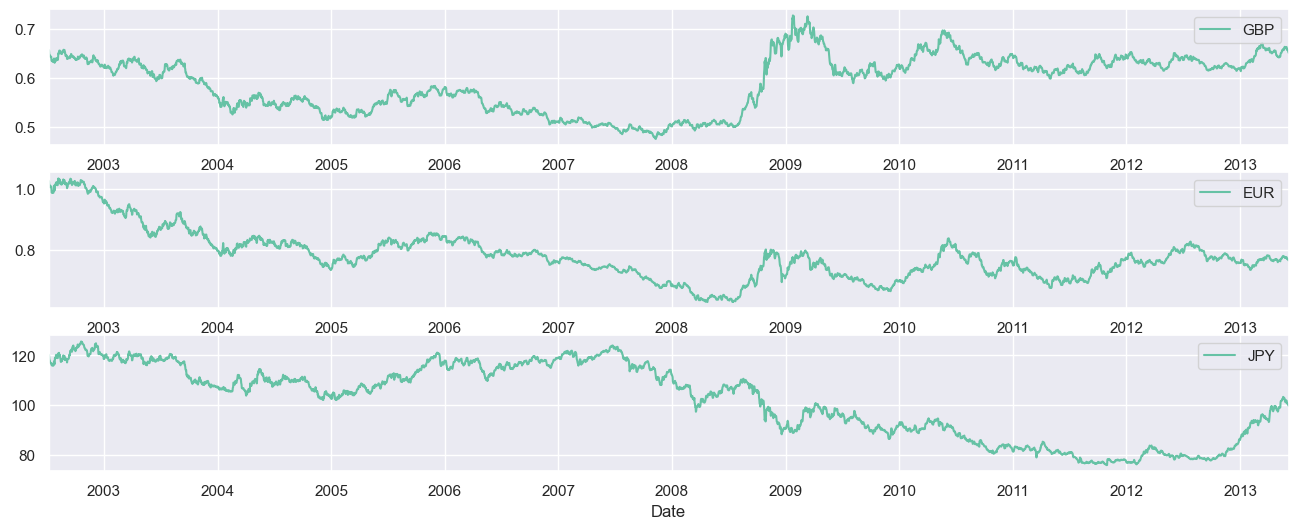

In [4]:
plt.subplot(311)
df['GBP'].plot(figsize=(16, 6), legend=True)
plt.subplot(312)
df['EUR'].plot(figsize=(16, 6), legend=True)
plt.subplot(313)
df['JPY'].plot(figsize=(16, 6), legend=True)

In [5]:
from statsmodels.tsa.stattools import adfuller, kpss

for x in ["GBP", "EUR", "JPY"]:
    adf_pval = adfuller(df[x], regression="n")[1]
    print(x)
    print(f"ADF, p-value: {adf_pval}")
    #kpss_stat, kpss_pval, lags, crit_vals = kpss(train_set[x])
    #print(f"KPSS, p-value: {kpss_pval}")

GBP
ADF, p-value: 0.6537975613380554
EUR
ADF, p-value: 0.18418575305194396
JPY
ADF, p-value: 0.39718872085870216


# Transformation

In [6]:
# difference
df = df.diff().dropna()

In [7]:
for x in ["GBP", "EUR", "JPY"]:
    adf_pval = adfuller(df[x], regression="n")[1]
    print(x)
    print(f"ADF, p-value: {adf_pval}")

GBP
ADF, p-value: 1.4795009031902523e-23
EUR
ADF, p-value: 0.0
JPY
ADF, p-value: 0.0


<Axes: xlabel='Date'>

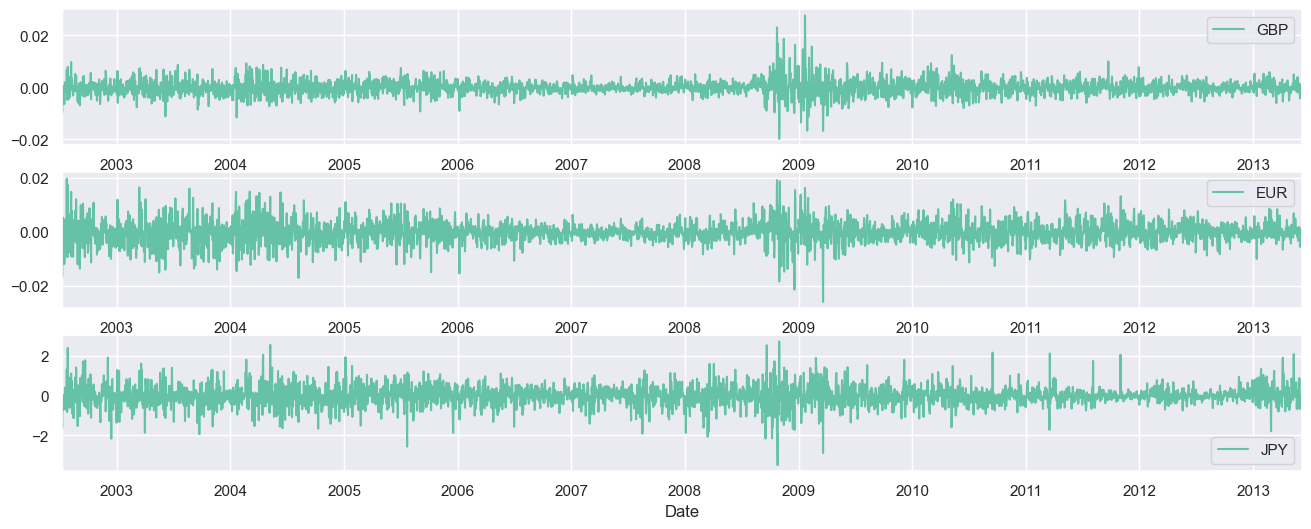

In [8]:
plt.subplot(311)
df['GBP'].plot(figsize=(16, 6), legend=True)
plt.subplot(312)
df['EUR'].plot(figsize=(16, 6), legend=True)
plt.subplot(313)
df['JPY'].plot(figsize=(16, 6), legend=True)

# Model development

## Create Forecaster

In [9]:
# future dates is the index of the test_set

forecaster = Forecaster(
    y=df['GBP'],
    current_dates=df.index,
    test_length=0.2,
    future_dates=365, # generate forecasts for the next year after the test set
    validation_length=4,
    metrics=['rmse', 'mae', get_mda],
    cis=False,
)
forecaster

Forecaster(
    DateStartActuals=2002-07-08T00:00:00.000000000
    DateEndActuals=2013-06-06T00:00:00.000000000
    Freq=D
    N_actuals=3987
    ForecastLength=365
    Xvars=[]
    TestLength=797
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

## Add predictors (ARs and covariates) to the Forecaster

### Determine the optimal number of lags (ARs)

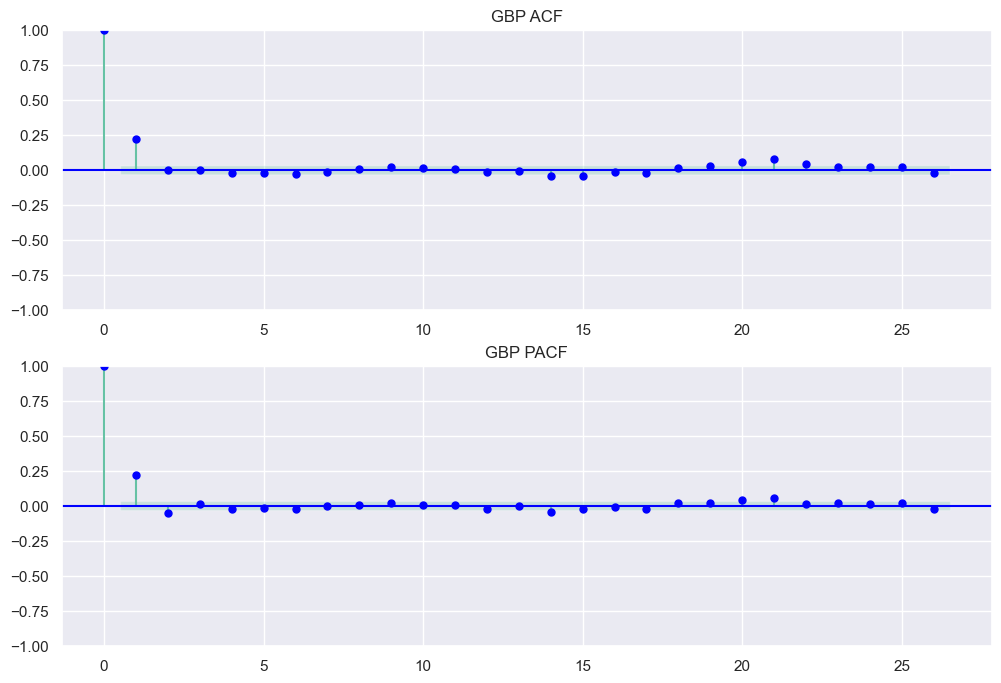

In [10]:
igs, axs = plt.subplots(2, figsize=(12, 8))
forecaster.plot_acf(
    ax=axs[0],
    title='GBP ACF',
    lags=26,
    color='blue'
)
forecaster.plot_pacf(
    ax=axs[1],
    title='GBP PACF',
    lags=26,
    color='blue',
    method='ywm'
)
plt.show()

## Add predictors

In [11]:
num_lags = 2

# autoregressive terms
forecaster.add_ar_terms(num_lags)

# covariates
forecaster.add_series(df["EUR"], called="EUR")
forecaster.add_series(df["JPY"], called="JPY")

# inspect the forecaster
forecaster

Forecaster(
    DateStartActuals=2002-07-08T00:00:00.000000000
    DateEndActuals=2013-06-06T00:00:00.000000000
    Freq=D
    N_actuals=3987
    ForecastLength=365
    Xvars=['AR1', 'AR2', 'EUR', 'JPY']
    TestLength=797
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

## Inspect created regressors

In [12]:
xvars = forecaster.export_Xvars_df()

# note this includes future_dates, and covariates
# for future_dates are unknown, hence are set to 0
xvars

,DATE,AR1,AR2,EUR,JPY
0,2002-07-08,NaN,NaN,-0.0013,-0.17
1,2002-07-09,-0.0005,NaN,-0.0165,-1.64
2,2002-07-10,-0.0096,-0.0005,-0.0031,-0.34
3,2002-07-11,-0.0017,-0.0096,0.0054,-0.37
4,2002-07-12,0.0006,-0.0017,-0.0005,-0.71
...,...,...,...,...,...
360,2014-06-02,NaN,NaN,0.0000,0.00
361,2014-06-03,NaN,NaN,0.0000,0.00
362,2014-06-04,NaN,NaN,0.0000,0.00
363,2014-06-05,NaN,NaN,0.0000,0.00


In [13]:
xvars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4352 entries, 0 to 364
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    4352 non-null   datetime64[ns]
 1   AR1     3987 non-null   float64       
 2   AR2     3987 non-null   float64       
 3   EUR     4352 non-null   float64       
 4   JPY     4352 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 204.0 KB


## Train models

In [14]:
models = ['naive', 'arima', 'rf'] # ('mlr', 'elasticnet', 'knn', 'rf', 'gbt', 'xgboost', 'mlp')
GridGenerator.get_example_grids()

In [15]:
# cross-validation settings
cv_params = {
    'k': 5,
    'set_aside_test_set': False
}

# dynamic_testing=False, as training should be done on reliable values
forecaster.tune_test_forecast(models, 
                              dynamic_testing=False,
                              cross_validate=True, 
                              #feature_importance=True,
                              verbose=True,
                              **cv_params
                             )

Num hyperparams to try for the naive model: 1.
Fold 0: Train size: 3323 (2002-07-08 00:00:00 - 2011-08-12 00:00:00). Test Size: 664 (2011-08-13 00:00:00 - 2013-06-06 00:00:00). 
Fold 1: Train size: 2659 (2002-07-08 00:00:00 - 2009-10-17 00:00:00). Test Size: 664 (2009-10-18 00:00:00 - 2011-08-12 00:00:00). 
Fold 2: Train size: 1995 (2002-07-08 00:00:00 - 2007-12-23 00:00:00). Test Size: 664 (2007-12-24 00:00:00 - 2009-10-17 00:00:00). 
Fold 3: Train size: 1331 (2002-07-08 00:00:00 - 2006-02-27 00:00:00). Test Size: 664 (2006-02-28 00:00:00 - 2007-12-23 00:00:00). 
Fold 4: Train size: 667 (2002-07-08 00:00:00 - 2004-05-04 00:00:00). Test Size: 664 (2004-05-05 00:00:00 - 2006-02-27 00:00:00). 
Chosen paramaters: {'seasonal': False}.
Num hyperparams to try for the arima model: 3.
Fold 0: Train size: 3323 (2002-07-08 00:00:00 - 2011-08-12 00:00:00). Test Size: 664 (2011-08-13 00:00:00 - 2013-06-06 00:00:00). 
Fold 1: Train size: 2659 (2002-07-08 00:00:00 - 2009-10-17 00:00:00). Test Size: 

## Feature importances

In [16]:
#f_rf = forecaster.export_feature_importance('rf')
#f_rf

## Cross-validation results

In [17]:
pd.set_option('display.float_format', '{:.4f}'.format)
ms = export_model_summaries({'GBP': forecaster}, determine_best_by='TestSetRMSE')
subms = ms[
    [
        'ModelNickname',
        'HyperParams',
        'InSampleRMSE',
        'InSampleMAE',
        'InSampleGET_MDA',
        'TestSetRMSE',
        'TestSetMAE',
        'TestSetGET_MDA'
    ]
]

from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(subms)

,ModelNickname,HyperParams,InSampleRMSE,InSampleMAE,InSampleGET_MDA,TestSetRMSE,TestSetMAE,TestSetGET_MDA
0,rf,"{'max_depth': 2, 'n_estimators': 100, 'max_features': 'sqrt', 'max_samples': 0.9}",0.0022,0.0014,0.7307,0.0015,0.0011,0.7462
1,arima,"{'order': (2, 0, 0)}",0.0026,0.0018,0.3991,0.0019,0.0014,0.0264
2,naive,{'seasonal': False},0.0034,0.0024,0.3749,0.0028,0.0023,0.0126


## Extract testset predictions

In [18]:
results = forecaster.export('lvl_test_set_predictions')
results['DATE'] = pd.to_datetime(results['DATE'])
results.set_index('DATE', inplace=True)
results

,actual,naive,arima,rf
DATE,,,,
2011-04-02,0.0011,-0.0020,-0.0004,0.0005
2011-04-03,-0.0020,-0.0020,-0.0000,-0.0013
2011-04-04,0.0000,-0.0020,0.0000,0.0004
2011-04-05,-0.0011,-0.0020,-0.0000,0.0003
2011-04-06,-0.0023,-0.0020,-0.0000,0.0007
...,...,...,...,...
2013-06-02,0.0006,-0.0020,-0.0000,0.0005
2013-06-03,0.0000,-0.0020,-0.0000,0.0003
2013-06-04,-0.0028,-0.0020,-0.0000,-0.0012


<Axes: xlabel='DATE'>

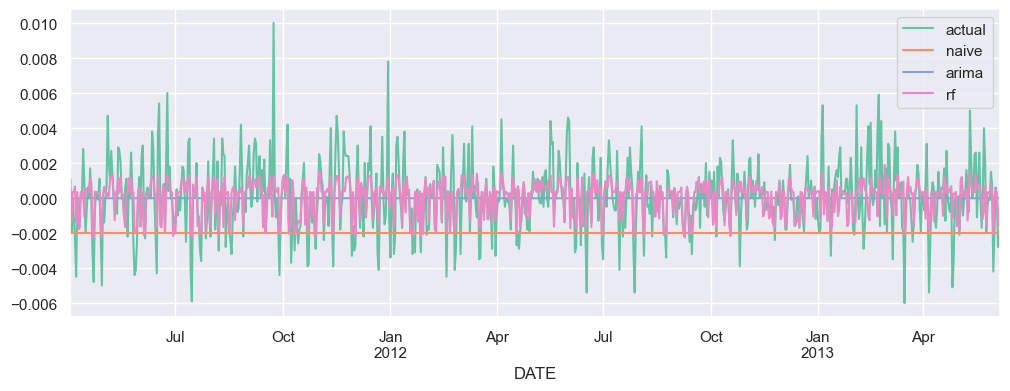

In [20]:
results.plot(figsize=(12, 4))

# Forecasts beyond the testset

In [21]:
# select model based on cross-validation result
forecaster.set_estimator('rf')

# dynamic_testing: Default True. Whether to dynamically/recursively test the forecast 
# (meaning AR terms will be propagated with predicted values). If True, evaluates 
# dynamically over the entire out-of-sample slice of data. If int, window evaluates 
# over that many steps (2 for 2-step dynamic forecasting, 12 for 12-step, etc.). 
# Setting this to False or 1 means faster performance, but gives a less-good indication 
# of how well the forecast will perform more than one period out. The model will skip
# testing if the test_length attribute is set to 0.
forecaster.manual_forecast(dynamic_testing=True) 

## Extract forecasted values

In [22]:
results = forecaster.export('lvl_fcsts')
results['DATE'] = pd.to_datetime(results['DATE'])
results.set_index('DATE', inplace=True)
results

,naive,arima,rf
DATE,,,
2013-06-07,-0.0017,-0.0003,-0.0000
2013-06-08,-0.0017,0.0000,-0.0000
2013-06-09,-0.0017,0.0000,-0.0000
2013-06-10,-0.0017,0.0000,-0.0000
2013-06-11,-0.0017,-0.0000,-0.0000
...,...,...,...
2014-06-02,-0.0017,-0.0000,-0.0000
2014-06-03,-0.0017,-0.0000,-0.0000
2014-06-04,-0.0017,-0.0000,-0.0000


<Axes: xlabel='DATE'>

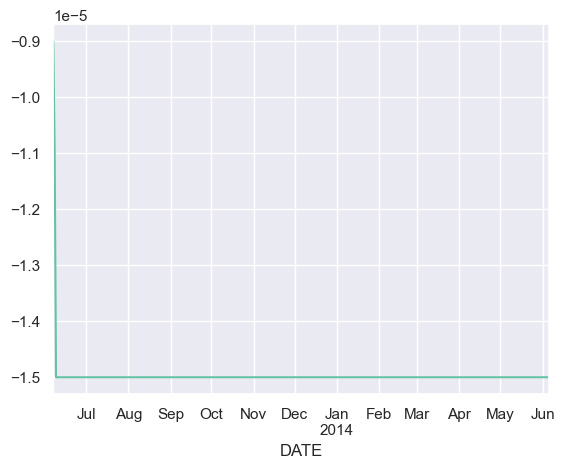

In [23]:
# plot
results['rf'].plot()